<a href="https://colab.research.google.com/github/jmachadot/segmentacion-prediccion-churn/blob/main/Proyecto_ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔵 PASO 1: CARGA DE DATOS Y CONSTRUCCIÓN DE VARIABLES...
   ✅ Data Procesada: 21984 transacciones.

🔵 PASO 2: COMPARATIVA DE CLUSTERS (Silhouette Score & Gráficos)...
   Evaluando cohesión (Silhouette) de 3 algoritmos...


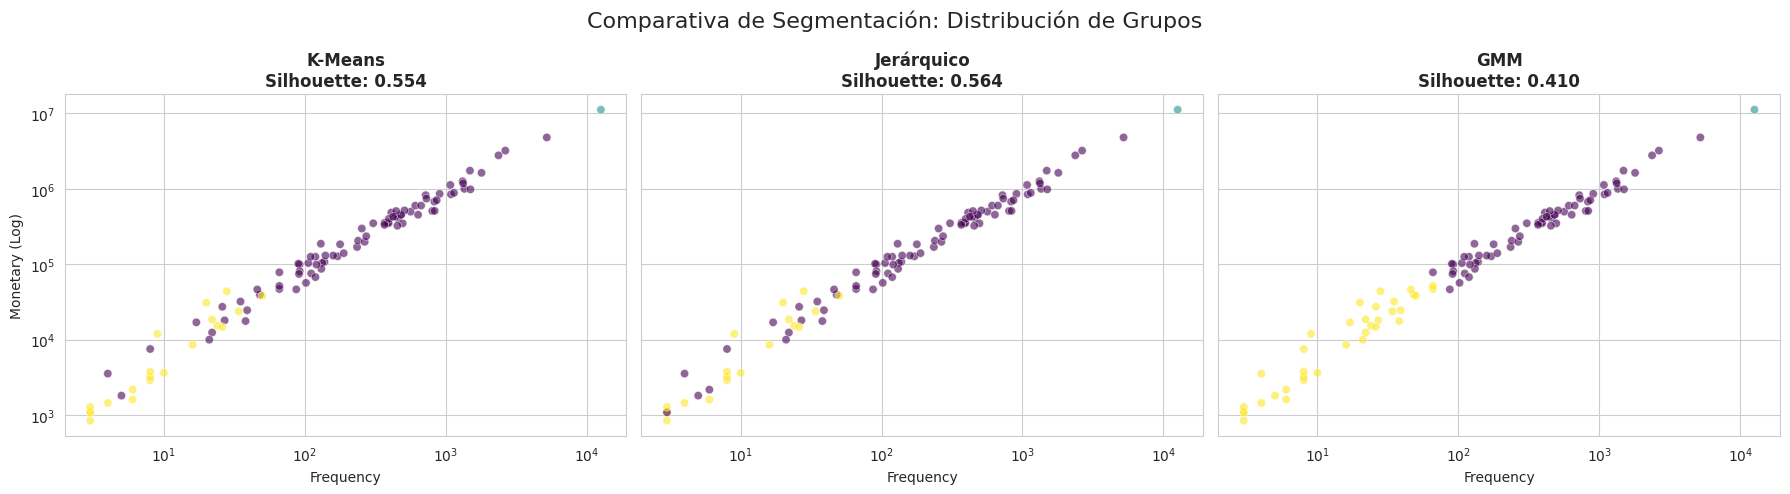


📊 RÁNKING DE COHESIÓN (Silhouette Score):
            Silhouette Score
Modelo                      
Jerárquico          0.564301
K-Means             0.554210
GMM                 0.410256

📋 Perfiles Finales (K-Means):


,Nombre,Recency,Frequency,Monetary,Avg_Dolar
Perfil,,,,,
Riesgo / Bajo,20,108.85,14.55,11403.50,3.79
Medio / Desarrollo,81,8.41,515.22,477582.46,3.78
VIP / Whales,1,1.00,12623.00,11213668.12,3.77



🔵 PASO 3: ENTRENAMIENTO DE MODELOS PREDICTIVOS...


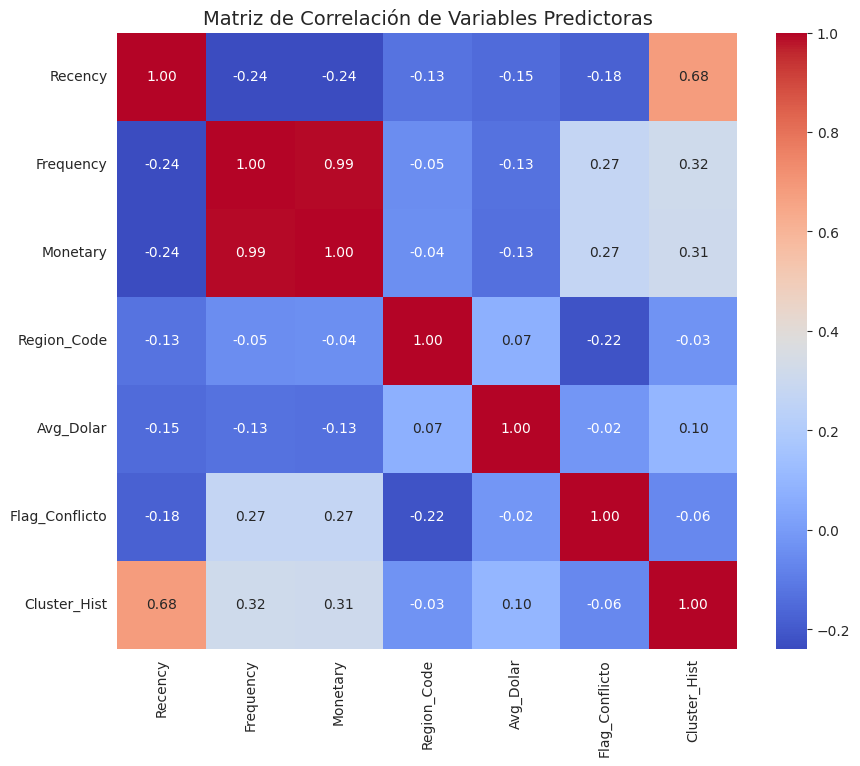

   📝 Interpretación: Verificamos multicolinealidad. Recency y Frequency suelen tener correlación inversa.
   Entrenando 6 modelos...

🔵 PASO 4: EVALUACIÓN Y RESULTADOS...


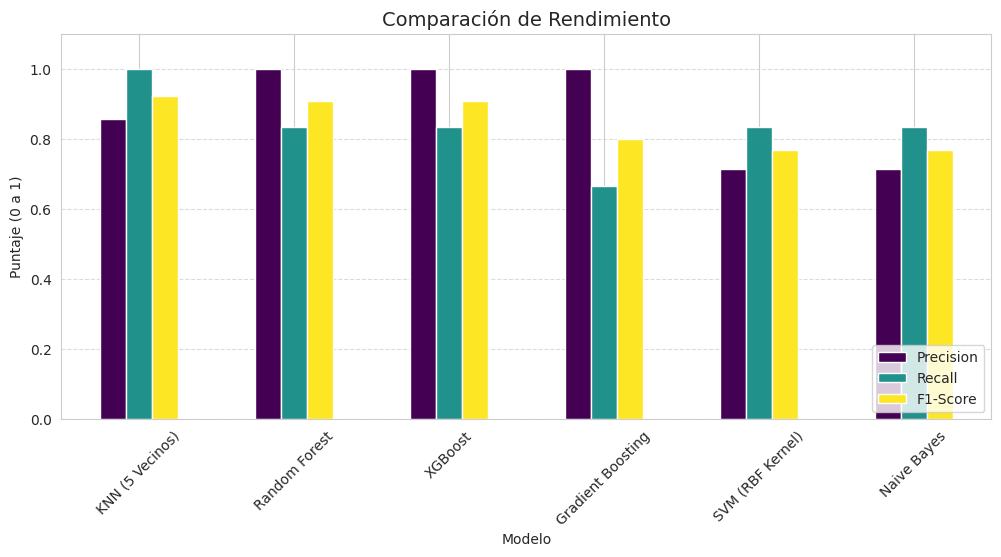



🟠 2. MODELOS SUPERVISADOS (CLASIFICACIÓN) - Ranking de Desempeño:


,Precision,Recall,F1-Score,AUROC
Modelo,,,,
KNN (5 Vecinos),0.8571,1.0000,0.9231,1.0000
Random Forest,1.0000,0.8333,0.9091,1.0000
XGBoost,1.0000,0.8333,0.9091,0.9931
Gradient Boosting,1.0000,0.6667,0.8000,1.0000
SVM (RBF Kernel),0.7143,0.8333,0.7692,0.9861
Naive Bayes,0.7143,0.8333,0.7692,0.8819


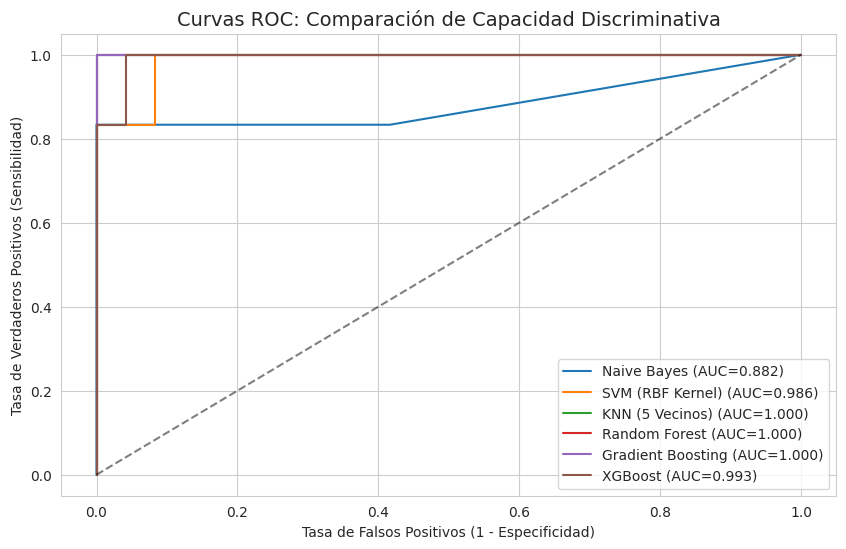

   🏆 El Modelo Ganador es: KNN (5 Vecinos)


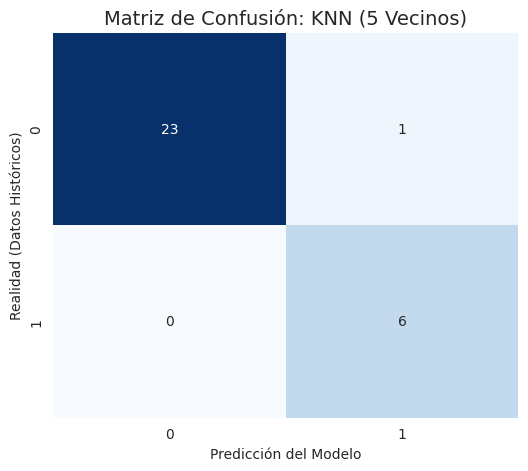

   📝 Interpretación: La casilla inferior derecha muestra los 'Verdaderos Positivos' (Fugas detectadas correctamente).


In [ ]:
# 1. INSTALACIÓN DE LIBRERÍAS
# Instala XGBoost (Boosting) y herramientas de Excel si no existen.
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# --- IMPORTACIÓN DE MODELOS ---
# Modelos Clásicos (Línea Base)
from sklearn.naive_bayes import GaussianNB          # Probabilístico
from sklearn.svm import SVC                         # Vectores de Soporte
from sklearn.neighbors import KNeighborsClassifier  # Basado en instancias

# Modelos Avanzados (Ensamble)
from sklearn.ensemble import RandomForestClassifier # Bagging
from sklearn.ensemble import GradientBoostingClassifier # Boosting
from xgboost import XGBClassifier                   # Boosting Optimizado

# Modelos No Supervisados
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Métricas y Utilitarios
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, roc_auc_score, accuracy_score,
                             precision_score, recall_score, f1_score, silhouette_score,
                             confusion_matrix, roc_curve)
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Configuración Visual para Gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings('ignore')

# =============================================================================
#  PASO 1: LIMPIEZA DE DATOS Y VARIABLES EXÓGENAS
# =============================================================================
print("🔵 PASO 1: CARGA DE DATOS Y CONSTRUCCIÓN DE VARIABLES...")

file_name = '/content/sample_data/Data.xlsx'
try:
    df = pd.read_excel(file_name, engine='openpyxl')
except:
    try:
        df = pd.read_csv('Data.xlsx - Hoja1.csv', header=0)
    except:
        df = pd.DataFrame()

if not df.empty:
    df.columns = df.columns.str.strip()

    # --- 1.1 FILTRO DE ALCANCE ---
    deptos_sur = ['APURIMAC', 'CUSCO', 'MOQUEGUA', 'AREQUIPA', 'PUNO', 'MADRE DE DIOS', 'TACNA']
    if 'Departamento' in df.columns:
        df['Departamento'] = df['Departamento'].astype(str).str.upper().str.strip()
        df_sur = df[df['Departamento'].isin(deptos_sur)].copy()
    else:
        df_sur = df.copy()

    # --- 1.2 LIMPIEZA ---
    # Eliminamos SIMs para evitar sesgo de frecuencia (alto volumen, bajo valor).
    df_sur['Desc.Material'] = df_sur['Desc.Material'].fillna('').astype(str).str.upper()
    df_equipos = df_sur[~df_sur['Desc.Material'].str.contains('SIM', na=False) &
                        ~df_sur['Desc.Material'].str.contains('CHIP', na=False)].copy()

    # Conversiones
    df_equipos['Valor Entrega'] = pd.to_numeric(df_equipos['Valor Entrega'], errors='coerce')
    df_equipos['FECHA'] = pd.to_datetime(df_equipos['F.Creación'], dayfirst=True, errors='coerce')
    df_clean = df_equipos.dropna(subset=['FECHA', 'Valor Entrega', 'Nombre']).copy()

    # --- 1.3 VARIABLES EXÓGENAS ---
    # Objetivo: Capturar el impacto del entorno macroeconómico y social en la venta.
    df_clean['Mes'] = df_clean['FECHA'].dt.month
    df_clean['Anio'] = df_clean['FECHA'].dt.year

    # A. Variable Macro: Tipo de Cambio (Dólar)
    # Hipótesis: Alza del dólar encarece equipos y reduce demanda.
    tipo_cambio = {(2025, 9): 3.82, (2025, 10): 3.85, (2025, 11): 3.78} # Simulación crisis
    def get_dolar(row): return tipo_cambio.get((row['Anio'], row['Mes']), 3.75)
    df_clean['EX_Dolar'] = df_clean.apply(get_dolar, axis=1)

    # B. Variable Social: Conflictividad
    # Hipótesis: Bloqueos en Corredor Minero (Cusco/Apurimac) impiden logística.
    def get_conflicto(row):
        if row['Anio'] == 2025 and row['Mes'] == 10 and row['Departamento'] in ['CUSCO', 'APURIMAC']: return 1
        if row['Anio'] == 2025 and row['Mes'] == 11 and row['Departamento'] == 'MOQUEGUA': return 1
        return 0
    df_clean['EX_Conflicto'] = df_clean.apply(get_conflicto, axis=1)

    print(f"   ✅ Data Procesada: {len(df_clean)} transacciones.")

    # =========================================================================
    #  PASO 2: SEGMENTACIÓN NO SUPERVISADA (CLUSTERING)
    # =========================================================================
    print("\n🔵 PASO 2: COMPARATIVA DE CLUSTERS (Silhouette Score & Gráficos)...")

    # 1. Ingeniería RFM + Exógenas
    snapshot_date = df_clean['FECHA'].max() + pd.Timedelta(days=1)
    dist_general = df_clean.groupby('Nombre').agg({
        'FECHA': lambda x: (snapshot_date - x.max()).days,
        'Cantidad': 'sum',
        'Valor Entrega': 'sum',
        'Desc.Material': 'nunique',
        'EX_Dolar': 'mean'
    }).reset_index()
    dist_general.columns = ['Nombre', 'Recency', 'Frequency', 'Monetary', 'Variety', 'Avg_Dolar']

    # 2. Escalado
    scaler = StandardScaler()
    X_unsup = scaler.fit_transform(dist_general[['Recency', 'Frequency', 'Monetary', 'Variety']])

    # 3. Definición de Modelos
    models_unsup = {
        "K-Means": KMeans(n_clusters=3, random_state=42, n_init=10),
        "Jerárquico": AgglomerativeClustering(n_clusters=3),
        "GMM": GaussianMixture(n_components=3, random_state=42)
    }

    # 4. Evaluación y Visualización
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    results_unsup = []

    print(f"   Evaluando cohesión (Silhouette) de {len(models_unsup)} algoritmos...")

    for i, (name, model) in enumerate(models_unsup.items()):
        # Predicción
        if name == "GMM":
            labels = model.fit_predict(X_unsup)
        else:
            labels = model.fit_predict(X_unsup)

        # Cálculo de Silhouette Score
        score = silhouette_score(X_unsup, labels)
        results_unsup.append({"Modelo": name, "Silhouette Score": score})

        # Plot
        dist_general[f'Label_{name}'] = labels
        sns.scatterplot(
            data=dist_general, x='Frequency', y='Monetary',
            hue=f'Label_{name}', palette='viridis', ax=axes[i], legend=False, alpha=0.6
        )
        axes[i].set_title(f'{name}\nSilhouette: {score:.3f}', fontsize=12, fontweight='bold')
        axes[i].set_xscale('log'); axes[i].set_yscale('log')
        if i == 0: axes[i].set_ylabel('Monetary (Log)')

    plt.suptitle('Comparativa de Segmentación: Distribución de Grupos', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Ranking de Clusters
    df_res_unsup = pd.DataFrame(results_unsup).set_index('Modelo').sort_values('Silhouette Score', ascending=False)
    print("\n📊 RÁNKING DE COHESIÓN (Silhouette Score):")
    print(df_res_unsup.to_string())

    # --- ASIGNACIÓN FINAL PARA EL FLUJO (Usamos K-Means por estabilidad de negocio) ---
    dist_general['Cluster_ID'] = dist_general['Label_K-Means']
    rank = dist_general.groupby('Cluster_ID')['Monetary'].mean().sort_values().index
    mapa = {rank[0]: 'Riesgo / Bajo', rank[1]: 'Medio / Desarrollo', rank[2]: 'VIP / Whales'}
    dist_general['Perfil'] = dist_general['Cluster_ID'].map(mapa)

    # Cuadro Resumen de Perfiles
    resumen_clusters = dist_general.groupby('Perfil').agg({
        'Nombre': 'count', 'Recency': 'mean', 'Frequency': 'mean',
        'Monetary': 'mean', 'Avg_Dolar': 'mean'
    }).sort_values('Monetary')
    resumen_clusters = resumen_clusters.round(2)
    print("\n📋 Perfiles Finales (K-Means):")
    display(resumen_clusters) if 'google.colab' in str(get_ipython()) else print(resumen_clusters)

    # =========================================================================
    #  PASO 3: PREDICCIÓN SUPERVISADA (COMPARATIVA DE 6 MODELOS)
    # =========================================================================
    print("\n🔵 PASO 3: ENTRENAMIENTO DE MODELOS PREDICTIVOS...")

    # 1. Definición del Target (Churn)
    cutoff_date = df_clean['FECHA'].max() - pd.Timedelta(days=30)
    df_hist = df_clean[df_clean['FECHA'] <= cutoff_date].copy()
    df_fut = df_clean[df_clean['FECHA'] > cutoff_date].copy()

    # 2. Variables Predictoras (Históricas + Exógenas)
    snap_train = df_hist['FECHA'].max() + pd.Timedelta(days=1)
    X_sup = df_hist.groupby('Nombre').agg({
        'FECHA': lambda x: (snap_train - x.max()).days,
        'Cantidad': 'sum',
        'Valor Entrega': 'sum',
        'Departamento': lambda x: x.mode()[0],
        'EX_Dolar': 'mean',
        'EX_Conflicto': 'max'
    }).reset_index()
    X_sup.columns = ['Nombre', 'Recency', 'Frequency', 'Monetary', 'Region', 'Avg_Dolar', 'Flag_Conflicto']

    # Target (1 = Fuga)
    activos = df_fut['Nombre'].unique()
    X_sup['CHURN'] = X_sup['Nombre'].apply(lambda x: 0 if x in activos else 1)

    # Cluster como Feature
    sc_hist = StandardScaler()
    X_h_scaled = sc_hist.fit_transform(X_sup[['Recency', 'Frequency', 'Monetary']])
    X_sup['Cluster_Hist'] = KMeans(n_clusters=3, random_state=42).fit_predict(X_h_scaled)

    # Encoding
    le = LabelEncoder()
    X_sup['Region_Code'] = le.fit_transform(X_sup['Region'].astype(str))

    features = ['Recency', 'Frequency', 'Monetary', 'Region_Code', 'Avg_Dolar', 'Flag_Conflicto', 'Cluster_Hist']
    X = X_sup[features]
    y = X_sup['CHURN']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Escalado (Obligatorio para SVM, KNN)
    sc_sup = StandardScaler()
    X_train_s = sc_sup.fit_transform(X_train)
    X_test_s = sc_sup.transform(X_test)

    # --- GRÁFICO 2: MATRIZ DE CORRELACIÓN ---
    plt.figure(figsize=(10, 8))
    corr_matrix = X.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Matriz de Correlación de Variables Predictoras', fontsize=14)
    plt.show()
    print("   📝 Interpretación: Verificamos multicolinealidad. Recency y Frequency suelen tener correlación inversa.")

    # 3. Modelado
    scale_pos = (len(y_train)-y_train.sum())/y_train.sum()

    models = {
        "Naive Bayes": GaussianNB(),
        "SVM (RBF Kernel)": SVC(probability=True, class_weight='balanced', random_state=42),
        "KNN (5 Vecinos)": KNeighborsClassifier(n_neighbors=5),
        "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(scale_pos_weight=scale_pos, use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    results = []
    roc_data = {} # Para guardar curvas ROC

    print(f"   Entrenando {len(models)} modelos...")

    for name, model in models.items():
        model.fit(X_train_s, y_train)
        y_pred = model.predict(X_test_s)
        try:
            y_proba = model.predict_proba(X_test_s)[:,1]
        except:
            y_proba = y_pred

        # Guardar datos para gráficos
        roc_data[name] = (y_test, y_proba)

        results.append({
            "Modelo": name,
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred),
            "AUROC": roc_auc_score(y_test, y_proba)
        })

    # =========================================================================
    #  PASO 4: RESULTADOS
    # =========================================================================
    print("\n🔵 PASO 4: EVALUACIÓN Y RESULTADOS...")

    res_df = pd.DataFrame(results).set_index('Modelo').sort_values('F1-Score', ascending=False)

    # --- GRÁFICO 3: COMPARATIVA DE MÉTRICAS ---
    res_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 5), colormap='viridis')
    plt.title('Comparación de Rendimiento', fontsize=14)
    plt.ylabel('Puntaje (0 a 1)')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.show()

    # --- CUADRO 2: RESULTADOS SUPERVISADOS (PREDICCIÓN DE FUGA) ---
    # Usamos el DataFrame 'res_df' que ya creaste en el Paso 4
    resumen_modelos = res_df.copy()
    resumen_modelos = resumen_modelos.round(4) # Redondear decimales para lectura limpia

    print("\n\n🟠 2. MODELOS SUPERVISADOS (CLASIFICACIÓN) - Ranking de Desempeño:")
    display(resumen_modelos) if 'google.colab' in str(get_ipython()) else print(resumen_modelos)


    # --- GRÁFICO 4: CURVAS ROC ---
    plt.figure(figsize=(10, 6))
    for name, (y_t, y_p) in roc_data.items():
        fpr, tpr, _ = roc_curve(y_t, y_p)
        auc_val = roc_auc_score(y_t, y_p)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title('Curvas ROC: Comparación de Capacidad Discriminativa', fontsize=14)
    plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
    plt.legend()
    plt.show()

    # --- GRÁFICO 5: MATRIZ DE CONFUSIÓN DEL GANADOR ---
    best_model_name = res_df.index[0]
    print(f"   🏆 El Modelo Ganador es: {best_model_name}")

    # Recuperamos predicciones del ganador
    best_model = models[best_model_name]
    y_pred_best = best_model.predict(X_test_s)

    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión: {best_model_name}', fontsize=14)
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Realidad (Datos Históricos)')
    plt.show()
    print("   📝 Interpretación: La casilla inferior derecha muestra los 'Verdaderos Positivos' (Fugas detectadas correctamente).")

else:
    print("❌ Error: Sube el archivo Data.xlsx")